# 01 - Basic Forecasting with sktime

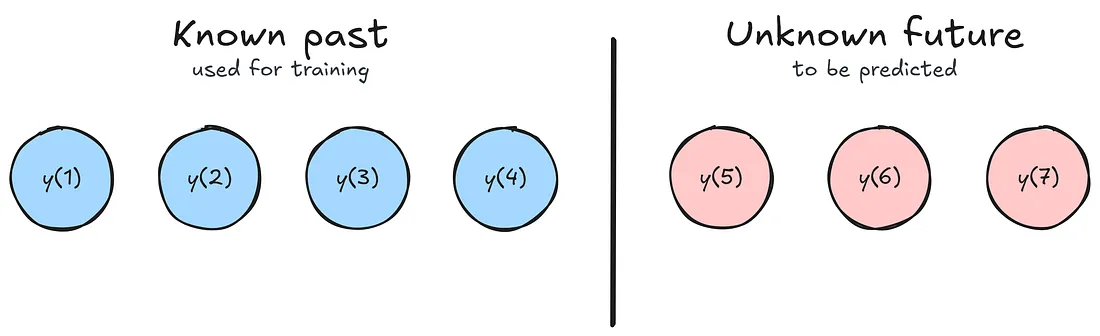

This notebook provides a practical guide to time series forecasting with **sktime**, covering:

*   Univariate forecasting (Naive, ETS) with model evaluation (train-test split, metrics, backtesting)
*   Forecasting with exogenous variables (SARIMAX)
*   Multivariate time series forecasting (ETS, VAR)
*   Regression models for forecasting (recursive, direct, and DirRec strategies)

## Univariate Forecasting
Load data and plot

In [1]:
from sktime.datasets import load_airline

y = load_airline()
y

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
           ...  
1960-08    606.0
1960-09    508.0
1960-10    461.0
1960-11    390.0
1960-12    432.0
Freq: M, Name: Number of airline passengers, Length: 144, dtype: float64

In [2]:
y.index

PeriodIndex(['1949-01', '1949-02', '1949-03', '1949-04', '1949-05', '1949-06',
             '1949-07', '1949-08', '1949-09', '1949-10',
             ...
             '1960-03', '1960-04', '1960-05', '1960-06', '1960-07', '1960-08',
             '1960-09', '1960-10', '1960-11', '1960-12'],
            dtype='period[M]', name='Period', length=144)

<Axes: xlabel='Period'>

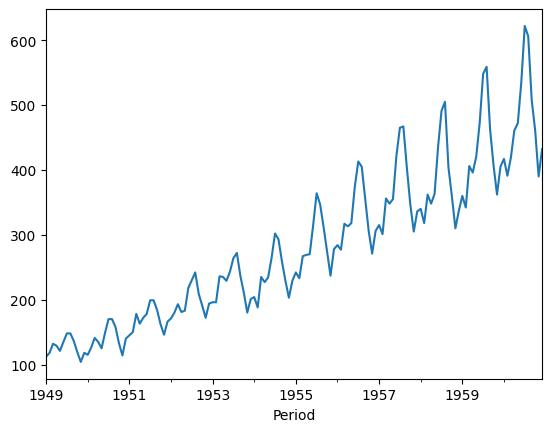

In [3]:
y.plot()

Properties:
- upward trend
- yearly seasonality
- increasing amplitude

⚠️ Warning: Time series data different from i.i.d. data you fit with sklearn. **The order is important!** Need specialized methods to deal with them.

### Naive forecasting
Just repeat the last 12 months.

In [4]:
import numpy as np
from sktime.forecasting.naive import NaiveForecaster

# step 1: specify the forecasting algorithm
naive = NaiveForecaster(strategy="last", sp=12)

# step 2: specify forecasting horizon
fh = np.arange(1, 25)  # we want to predict the next 24 months, i.e. month 1 - 24.

# step 3: fit the forecaster
naive.fit(y, fh=fh)

# step 4: make the forecast
y_pred = naive.predict()

In [5]:
y_pred

1961-01    417.0
1961-02    391.0
1961-03    419.0
1961-04    461.0
1961-05    472.0
1961-06    535.0
1961-07    622.0
1961-08    606.0
1961-09    508.0
1961-10    461.0
1961-11    390.0
1961-12    432.0
1962-01    417.0
1962-02    391.0
1962-03    419.0
1962-04    461.0
1962-05    472.0
1962-06    535.0
1962-07    622.0
1962-08    606.0
1962-09    508.0
1962-10    461.0
1962-11    390.0
1962-12    432.0
Freq: M, Name: Number of airline passengers, dtype: float64

$$\text{Seasonal Naive Model:} \quad \hat{y}_{t+h|t} = y_{t+h-\mathrm{sp} \cdot k}$$

Read: "The forecast $h$ steps into the future (i.e., $t+h$) when the model was trained up to time $t$ is ..."

In [6]:
y_pred.head(13)

1961-01    417.0
1961-02    391.0
1961-03    419.0
1961-04    461.0
1961-05    472.0
1961-06    535.0
1961-07    622.0
1961-08    606.0
1961-09    508.0
1961-10    461.0
1961-11    390.0
1961-12    432.0
1962-01    417.0
Freq: M, Name: Number of airline passengers, dtype: float64

Plot utils for nice visualizations. 

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

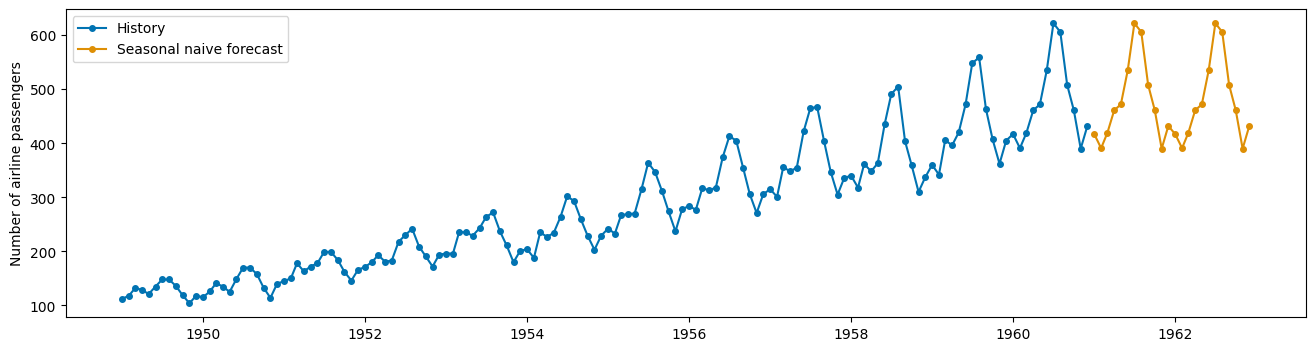

In [7]:
from sktime.utils.plotting import plot_series

plot_series(y, y_pred, labels=["History", "Seasonal naive forecast"])

Surprisingly, sometimes hard to beat. But not in this case. 

We use **Exponential Smoothing** to get a better fit.  Old, but no joke: 92.5% of people in the M5 challenge couldn't beat it. [(Link)](https://www.sciencedirect.com/science/article/pii/S0169207021001874)

$$\text{Simple Exponential Smoothing:} \quad \hat{y}_{t+h|t} = \alpha y_t + (1 - \alpha) \hat{y}_{t} = \alpha \sum_{i=0}^{t} (1 - \alpha)^i y_{t-i}$$

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

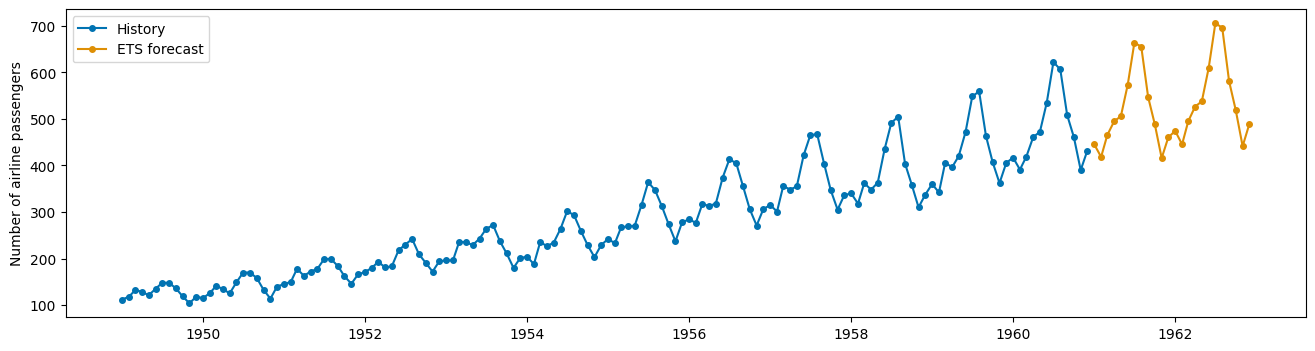

In [8]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

ets = ExponentialSmoothing(trend="add", seasonal="mul", sp=12)

# same methods!
ets.fit(y, fh=fh)
y_pred = ets.predict()

plot_series(y, y_pred, labels=["History", "ETS forecast"])

\begin{align*}
\text{Forecasting Equation:} \quad & \hat{y}_{t+h|t} = \ell_t + h b_t + s_{t+h-\mathrm{sp}\cdot k} \\
\text{Level Equation:} \quad & \ell_t = \alpha (y_t - s_{t-m}) + (1 - \alpha)(\ell_{t-1} + b_{t-1}) \\
\text{Trend Equation:} \quad & b_t = \beta^* (\ell_t - \ell_{t-1}) + (1 - \beta^*) b_{t-1} \\
\text{Seasonal Equation:} \quad & s_t = \gamma (y_t - \ell_{t-1} - b_{t-1}) + (1 - \gamma) s_{t-\mathrm{sp}}
\end{align*}

So far only two forecasters, but sktime offers a marketplace of them. Most of them from famous libraries:
- statsmodels
- pmdarima
- pytorch-forecasting (part of sktime)
- prophet
- Nixtla-verse
- ...
 
but some implemented by the sktime community.

In [9]:
from sktime.registry import all_estimators

all_estimators(
    estimator_types="forecaster",
    as_dataframe=True,
)

,name,object
0,ARCH,<class 'sktime.forecasting.arch._uarch.ARCH'>
1,ARDL,<class 'sktime.forecasting.ardl.ARDL'>
2,ARIMA,<class 'sktime.forecasting.arima._pmdarima.ARI...
3,AutoARIMA,<class 'sktime.forecasting.arima._pmdarima.Aut...
4,AutoETS,<class 'sktime.forecasting.ets.AutoETS'>
...,...,...
111,VAR,<class 'sktime.forecasting.var.VAR'>
112,VARMAX,<class 'sktime.forecasting.varmax.VARMAX'>
113,VARReduce,<class 'sktime.forecasting.var_reduce.VARReduce'>
114,VECM,<class 'sktime.forecasting.vecm.VECM'>


The best part: **fit-predict works everywhere**.

### Model Evaluation
First, just a small visual inspection.

(120,)
(24,)


(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

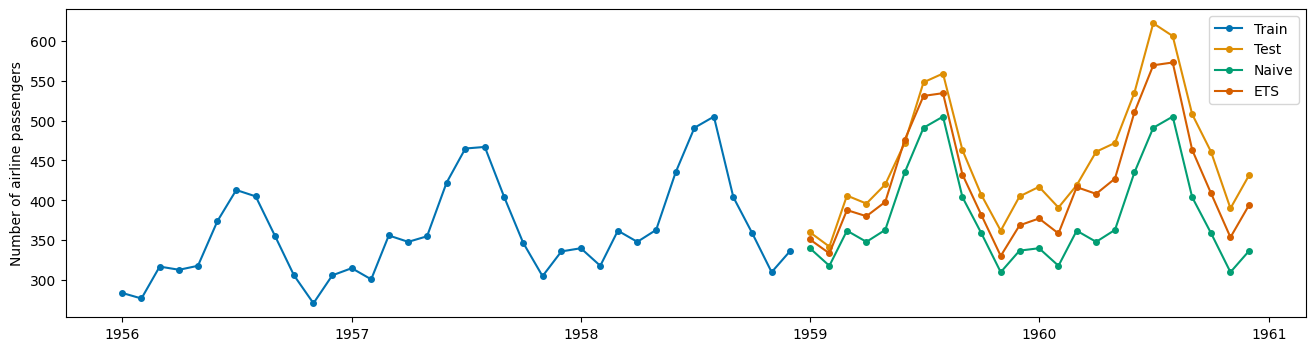

In [10]:
from sktime.split import temporal_train_test_split

# like in sklearn, but repects time
y_train, y_test = temporal_train_test_split(y, test_size=24)
print(y_train.shape)
print(y_test.shape)

naive.fit(y_train, fh=fh)
ets.fit(y_train, fh=fh)

plot_series(
    y_train.tail(36),
    y_test,
    naive.predict(),
    ets.predict(),
    labels=["Train", "Test", "Naive", "ETS"],
)

Now, let's talk numbers.

In [11]:
from sktime.performance_metrics.forecasting import (
    MeanAbsoluteError,
    MeanAbsolutePercentageError,
    # MeanSquaredScaledError,
)

# todo: mention msse

mae = MeanAbsoluteError()
mape = MeanAbsolutePercentageError()
smape = MeanAbsolutePercentageError(symmetric=True)

$$MAE = \frac{1}{n} \sum_{t=1}^{n} \left| y_t - \hat{y}_t \right|,\ MAPE = \frac{1}{n} \sum_{t=1}^{n} \left| \frac{y_t - \hat{y}_t}{y_t} \right|,\ SMAPE = \frac{1}{n} \sum_{t=1}^{n} \frac{\left| y_t - \hat{y}_t \right|}{\frac{\left| y_t \right| + \left| \hat{y}_t \right|}{2}}$$

In [12]:
for _metric in [mape, smape, mae]:
    for _model in [naive, ets]:
        print(_metric, _model, _metric(y_test, _model.predict(fh=fh)))

MeanAbsolutePercentageError() NaiveForecaster(sp=12) 0.15523355162420377
MeanAbsolutePercentageError() ExponentialSmoothing(seasonal='mul', sp=12, trend='add') 0.06390856851590097
MeanAbsolutePercentageError(symmetric=True) NaiveForecaster(sp=12) 0.17012625361650954
MeanAbsolutePercentageError(symmetric=True) ExponentialSmoothing(seasonal='mul', sp=12, trend='add') 0.06655010327310072
MeanAbsoluteError() NaiveForecaster(sp=12) 71.25
MeanAbsoluteError() ExponentialSmoothing(seasonal='mul', sp=12, trend='add') 28.976429145804236


⚠️ Warning: A single split is typically not enough in time series forecasting.

Imagine: 
- daily forecast data 
- test set is only June
- you performance only **in June**
- in case of a good result: could have been luck
- could be completely different in other months. 

Better:

### Backtesting
Aka: do train-test splits repeatedly.

In [13]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.split import ExpandingWindowSplitter
from sktime.utils import plot_windows

(<Figure size 1600x480 with 1 Axes>,
 <Axes: xlabel='Time', ylabel='Window number'>)

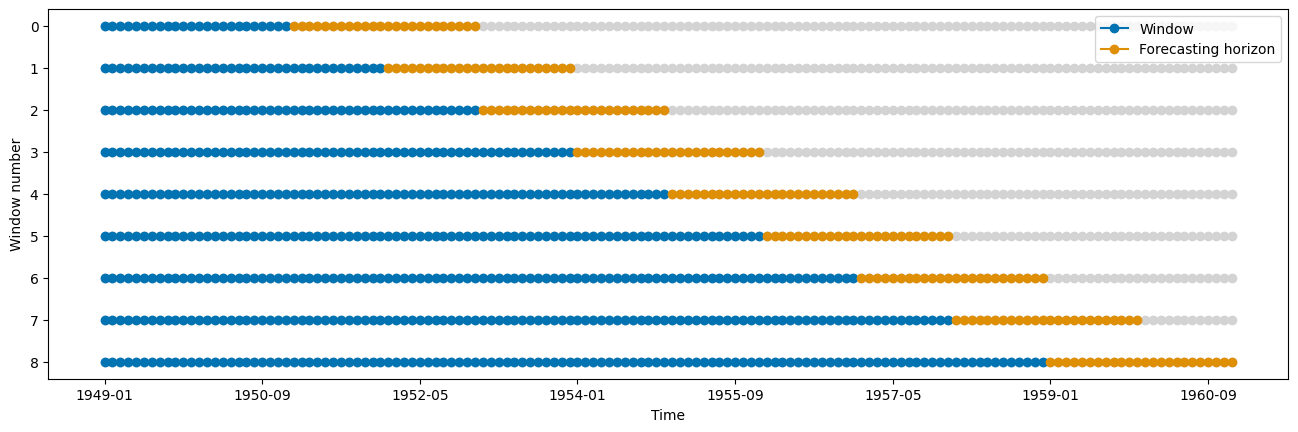

In [14]:
cv = ExpandingWindowSplitter(fh=fh, initial_window=24, step_length=12)
plot_windows(cv=cv, y=y)

In [15]:
cv_results = evaluate(forecaster=ets, cv=cv, y=y, scoring=[mape, mae])

cv_results

,test_MeanAbsolutePercentageError,test_MeanAbsoluteError,fit_time,pred_time,len_train_window,cutoff
0,0.098273,18.394332,0.060225,0.002305,24,1950-12
1,0.041002,8.871544,0.023334,0.001928,36,1951-12
2,0.042008,9.130033,0.025187,0.002110,48,1952-12
3,0.061213,16.931883,0.024206,0.001864,60,1953-12
4,0.093683,30.305182,0.025038,0.002162,72,1954-12
5,0.043648,16.636724,0.028841,0.002157,84,1955-12
6,0.036625,14.561681,0.030679,0.002107,96,1956-12
7,0.042526,16.950233,0.032767,0.002049,108,1957-12
8,0.063909,28.976429,0.032315,0.002344,120,1958-12


In [16]:
extended_cv_results = evaluate(
    forecaster=ets,
    cv=cv,
    y=y,
    scoring=[mape, mae],
    return_data=True,
)

extended_cv_results.head(3)

,test_MeanAbsolutePercentageError,test_MeanAbsoluteError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,0.098273,18.394332,0.063555,0.002360,24,1950-12,1949-01 112.0 1949-02 118.0 1949-03 1...,1951-01 145.0 1951-02 150.0 1951-03 1...,1951-01 136.179666 1951-02 146.167584 19...
1,0.041002,8.871544,0.023153,0.002283,36,1951-12,1949-01 112.0 1949-02 118.0 1949-03 1...,1952-01 171.0 1952-02 180.0 1952-03 1...,1952-01 168.518122 1952-02 177.629826 19...
2,0.042008,9.130033,0.025508,0.002033,48,1952-12,1949-01 112.0 1949-02 118.0 1949-03 1...,1953-01 196.0 1953-02 196.0 1953-03 2...,1953-01 197.374256 1953-02 207.547412 19...


(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

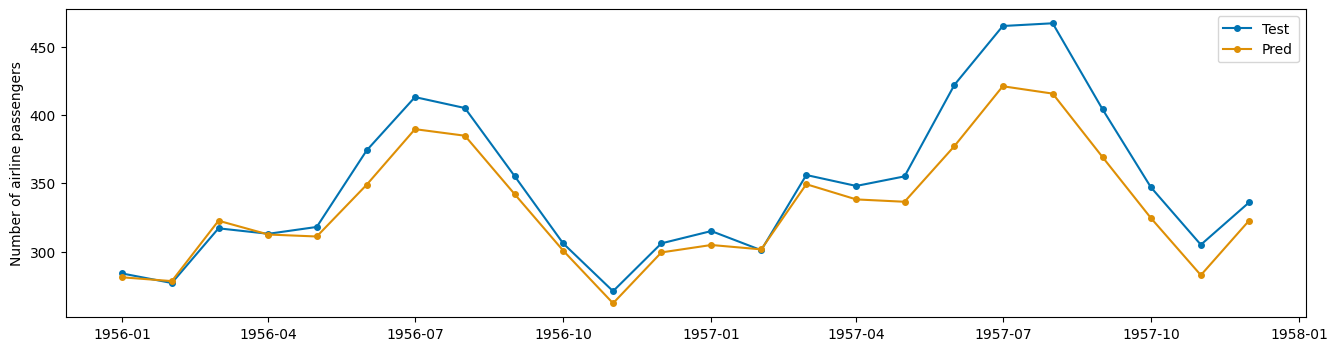

In [17]:
plot_series(
    extended_cv_results.loc[5, "y_test"],
    extended_cv_results.loc[5, "y_pred"],
    labels=["Test", "Pred"],
)

## Exogenous variables
Let's forecast when we have more information!

<img src="imgs/exogenous_variables_complete.png" alt="placeholder" width="50%">

In [18]:
from sktime.datasets import load_longley

y, X = load_longley()

Variable name definitions:

- TOTEMP - Total Employment
- GNPDEFL - GNP deflator
- GNP - GNP
- UNEMP - Number of unemployed
- ARMED - Size of armed forces
- POP - Population
- YEAR - Year (1947 - 1962)

In [19]:
print(type(X))
X.head()

<class 'pandas.core.frame.DataFrame'>


,GNPDEFL,GNP,UNEMP,ARMED,POP
Period,,,,,
1947,83.0,234289.0,2356.0,1590.0,107608.0
1948,88.5,259426.0,2325.0,1456.0,108632.0
1949,88.2,258054.0,3682.0,1616.0,109773.0
1950,89.5,284599.0,3351.0,1650.0,110929.0
1951,96.2,328975.0,2099.0,3099.0,112075.0


Five exogenous variables.

In [20]:
print(y.shape)
y.head()

(16,)


Period
1947    60323.0
1948    61122.0
1949    60171.0
1950    61187.0
1951    63221.0
Freq: Y-DEC, Name: TOTEMP, dtype: float64

In [21]:
from sktime.forecasting.arima import ARIMA  # one of many ARIMAs, actually SARIMAX
from sktime.split import temporal_train_test_split

fh = np.arange(1, 8)
y_train, y_test, X_train, X_test = temporal_train_test_split(
    y=y,
    X=X,
    test_size=7,
)

print(y_train.shape)
print(y_test.shape)
print(X_train.shape)
print(X_test.shape)

(9,)
(7,)
(9, 5)
(7, 5)


In [22]:
fh

array([1, 2, 3, 4, 5, 6, 7])

In [26]:
print(len(fh))

7


In [47]:
#from pmdarima import ARIMA 
from sktime.forecasting.arima import ARIMA
arima = ARIMA(order=(2, 1, 2)).fit(y_train, fh=fh)
arimax = ARIMA(order=(2, 1, 2)).fit(y_train, X=X_train, fh=fh)

/Users/eugenechua/.pyenv/versions/SKTIME/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/eugenechua/.pyenv/versions/SKTIME/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [48]:
print(X_test.shape)
print(len(fh))

(7, 5)
7


In [49]:
arima.predict()

/Users/eugenechua/.pyenv/versions/SKTIME/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


1956    66654.935801
1957    65906.375468
1958    65165.667548
1959    65802.391169
1960    66631.404930
1961    66119.084081
1962    65220.760404
Freq: Y-DEC, Name: TOTEMP, dtype: float64

In [50]:
print("stored fh:", arima._fh)             
print("length of stored fh:", len(arima._fh))


stored fh: ForecastingHorizon([1, 2, 3, 4, 5, 6, 7], dtype='int64', is_relative=True)
length of stored fh: 7


/Users/eugenechua/.pyenv/versions/SKTIME/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/eugenechua/.pyenv/versions/SKTIME/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='TOTEMP'>)

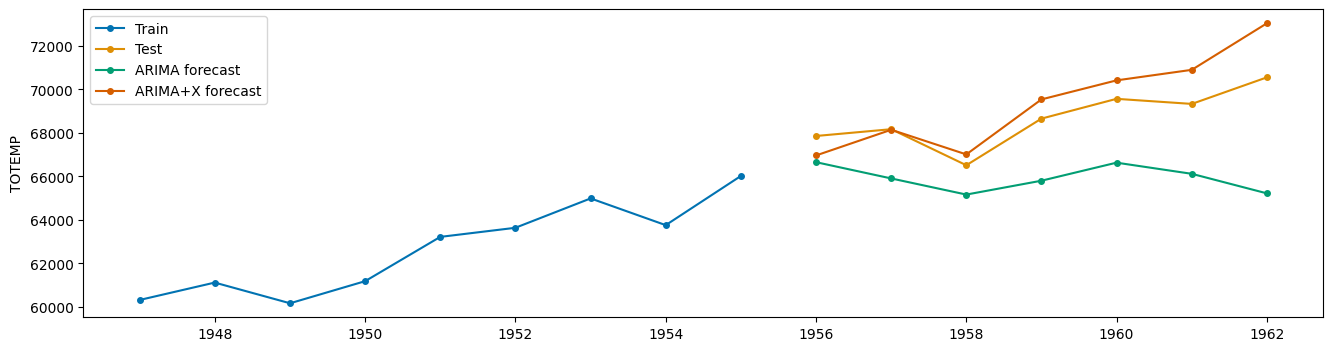

In [52]:
plot_series(
    y_train,
    y_test,
    arima.predict(),
    arimax.predict(X=X_test),
    labels=["Train", "Test", "ARIMA forecast", "ARIMA+X forecast"],
)

We can always check what the models have learned.

In [38]:
arimax.get_fitted_params()

{'intercept': 0.012473085882126827,
 'GNPDEFL': -42.43254015910101,
 'GNP': 0.03898412708245786,
 'UNEMP': -0.750422264471157,
 'ARMED': -0.5109879603812741,
 'POP': 0.19574206591466267,
 'ar.L1': -0.2191698608684406,
 'ar.L2': 0.7447523967976757,
 'ma.L1': -0.0049905093722808075,
 'ma.L2': -0.873030990858423,
 'sigma2': 43338.933280508645,
 'aic': 124.20042622824931,
 'aicc': inf,
 'bic': 125.07428318672751,
 'hqic': 118.30661232615111}

For models coming from the **statsmodels** package:

In [23]:
arimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                    9
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 -51.102
Date:                Thu, 10 Apr 2025   AIC                            124.203
Time:                        21:37:04   BIC                            125.077
Sample:                    12-31-1947   HQIC                           118.310
                         - 12-31-1955                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0125      0.003      3.750      0.000       0.006       0.019
GNPDEFL      -42.4329      0.387   -109.642      0.000     -43.191     -41.674
GNP            0.0390      0.049      0.804      0.422      -0.056       0.134
UNEMP         -0.7485      0.905     -0.827      0.408      -2.522       1.025
ARMED         -0.5100      1.210     -0.421      0.673      -2.882       1.862
POP            0.1958      0.611      0.321      0.748      -1.001       1.392
ar.L1         -0.2202      3.813     -0.058      0.954      -7.693       7.253
ar.L2          0.7439      1.077      0.690      0.490      -1.368       2.856
ma.L1         -0.0055      6.833     -0.001      0.999     -13.398      13.387
ma.L2         -0.8739      2.728     -0.320      0.749      -6.221       4.473
sigma2      4.334e+04      0.001   6.99e+07      0.000    4.33e+04    4.33e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.59   Jarque-Bera (JB):                 0.71
Prob(Q):                              0.44   Prob(JB):                         0.70
Heteroskedasticity (H):               0.41   Skew:                            -0.23
Prob(H) (two-sided):                  0.49   Kurtosis:                         1.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.26e+24. Standard errors may be unstable.
"""

### What if we don't have future exogenous data?

In [24]:
arimax.fit(y=y, X=X, fh=fh)

c:\Users\rober\Desktop\sktime\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ARIMA(order=(2, 1, 2))

**Will fail since we need X for the forecasting horizon as well.**

<img src="imgs/exogenous_variables_missing.png" alt="placeholder" width="50%">

In [25]:
try:
    arimax.predict()
except ValueError as e:
    print(e)

When an ARIMA is fit with an X array, it must also be provided one for predicting or updating observations.


Solution: 
1. Forecast `X` first using another model.
2. Input this forecast into the main model for `y`.

<img src="imgs/exogenous_variables_forecasted.png" alt="placeholder" width="50%">

In [26]:
from sktime.forecasting.compose import ForecastX

arimax_plus_exo = ForecastX(
    forecaster_y=ARIMA(order=(2, 1, 2)),
    forecaster_X=ExponentialSmoothing(trend="add"),
)

arimax_plus_exo.fit(y, X, fh=fh)

c:\Users\rober\Desktop\sktime\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ForecastX(forecaster_X=ExponentialSmoothing(trend='add'),
          forecaster_y=ARIMA(order=(2, 1, 2)))

c:\Users\rober\Desktop\sktime\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='TOTEMP'>)

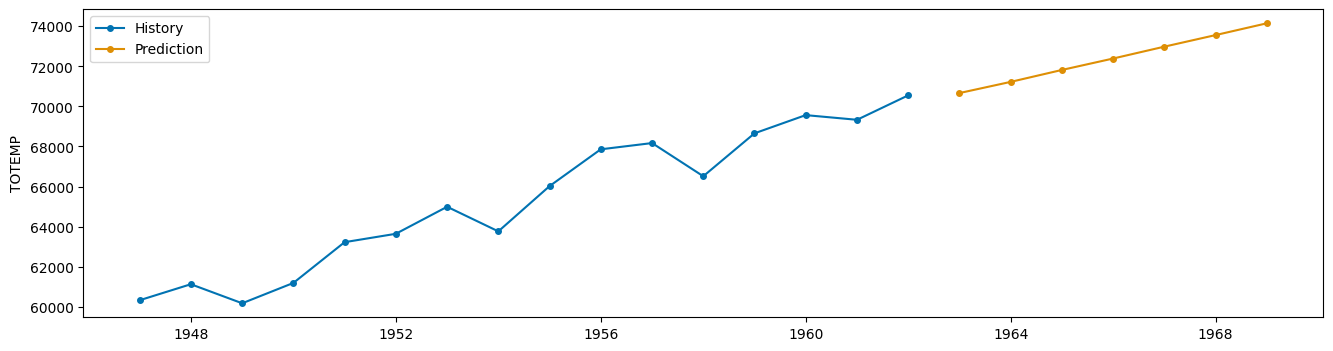

In [27]:
plot_series(y, arimax_plus_exo.predict(), labels=["History", "Prediction"])

Get the predictions for `X`.

In [28]:
arimax_plus_exo.forecaster_X_.predict()

,GNPDEFL,GNP,UNEMP,ARMED,POP
1963,120.777680,563821.430621,4295.642397,2894.824461,132287.736223
1964,123.024313,584524.411275,4425.383133,2963.650554,134497.786663
1965,125.270947,605227.391930,4555.123869,3032.476648,136707.837103
1966,127.517581,625930.372584,4684.864605,3101.302742,138917.887542
1967,129.764214,646633.353239,4814.605341,3170.128835,141127.937982
1968,132.010848,667336.333893,4944.346076,3238.954929,143337.988422
1969,134.257481,688039.314548,5074.086812,3307.781022,145548.038861


## Multivariate Data
We use the same data, but forecast many time series now, not only one.

In [29]:
_, y = load_longley()

y.head()

,GNPDEFL,GNP,UNEMP,ARMED,POP
Period,,,,,
1947,83.0,234289.0,2356.0,1590.0,107608.0
1948,88.5,259426.0,2325.0,1456.0,108632.0
1949,88.2,258054.0,3682.0,1616.0,109773.0
1950,89.5,284599.0,3351.0,1650.0,110929.0
1951,96.2,328975.0,2099.0,3099.0,112075.0


Easy with sktime, use a forecaster you like and put the entire dataframe in. Common pattern: **Structure of `y` is structure of the forecast.**

In [30]:
ets = ExponentialSmoothing(trend="add")

ets.fit(y, fh=fh)

y_pred = ets.predict()
y_pred

,GNPDEFL,GNP,UNEMP,ARMED,POP
Period,,,,,
1963,120.777680,563821.430621,4295.642397,2894.824461,132287.736223
1964,123.024313,584524.411275,4425.383133,2963.650554,134497.786663
1965,125.270947,605227.391930,4555.123869,3032.476648,136707.837103
1966,127.517581,625930.372584,4684.864605,3101.302742,138917.887542
1967,129.764214,646633.353239,4814.605341,3170.128835,141127.937982
1968,132.010848,667336.333893,4944.346076,3238.954929,143337.988422
1969,134.257481,688039.314548,5074.086812,3307.781022,145548.038861


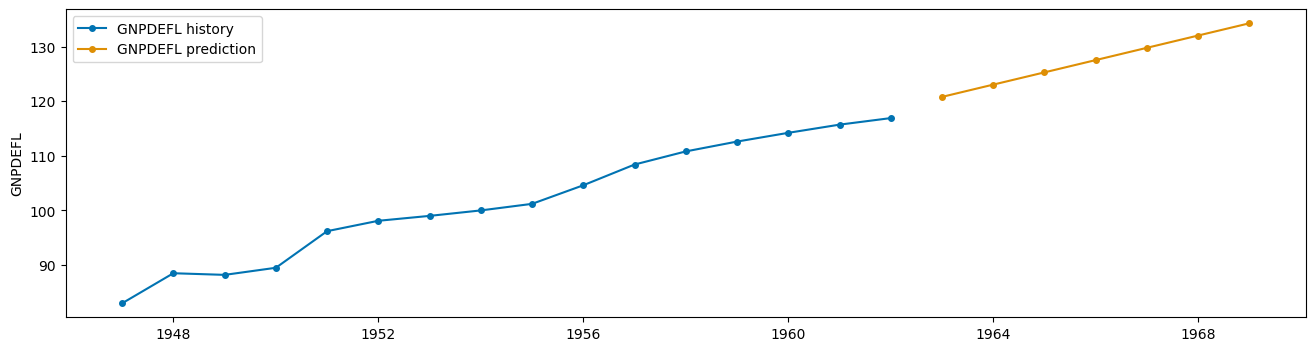

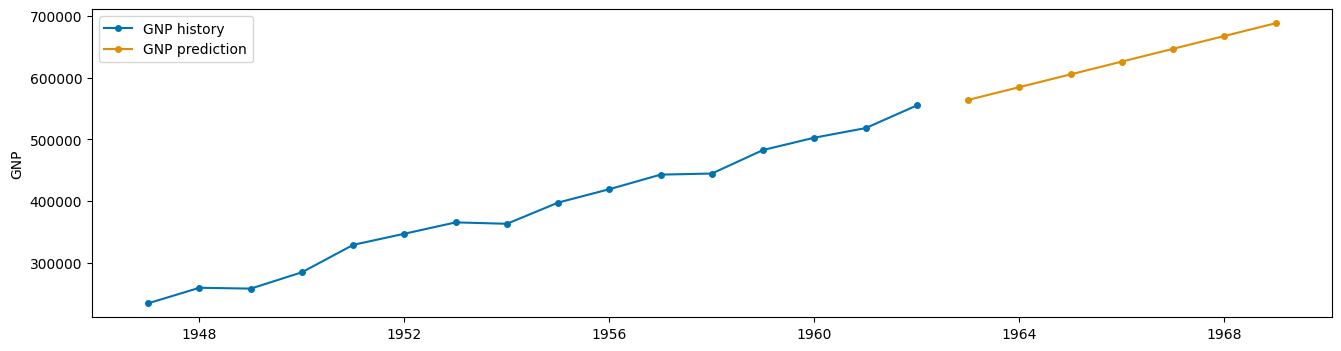

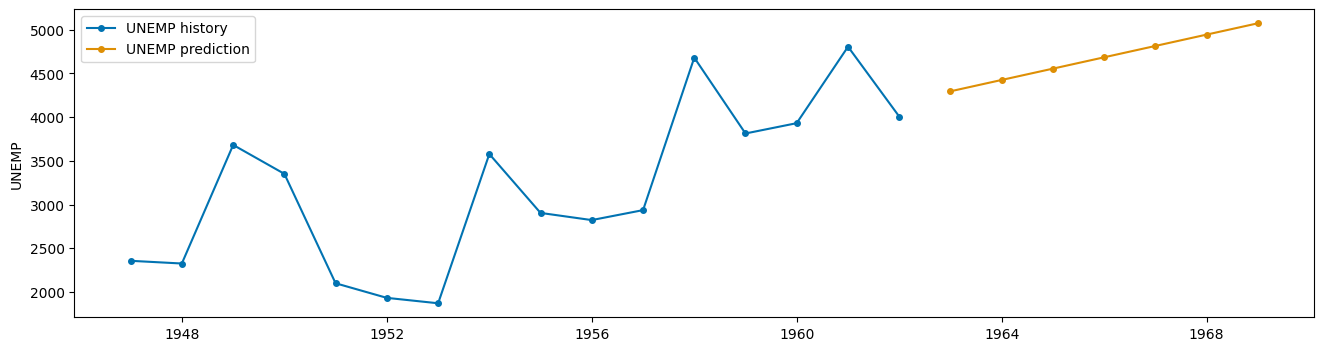

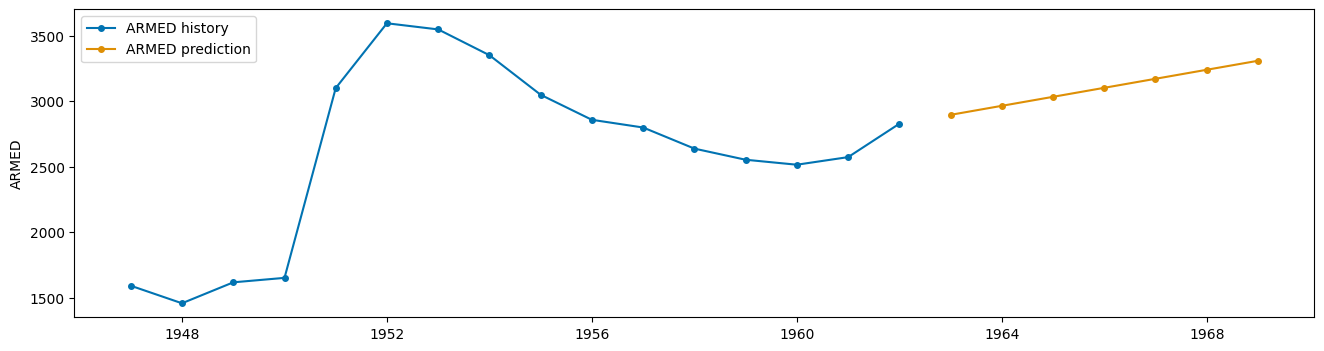

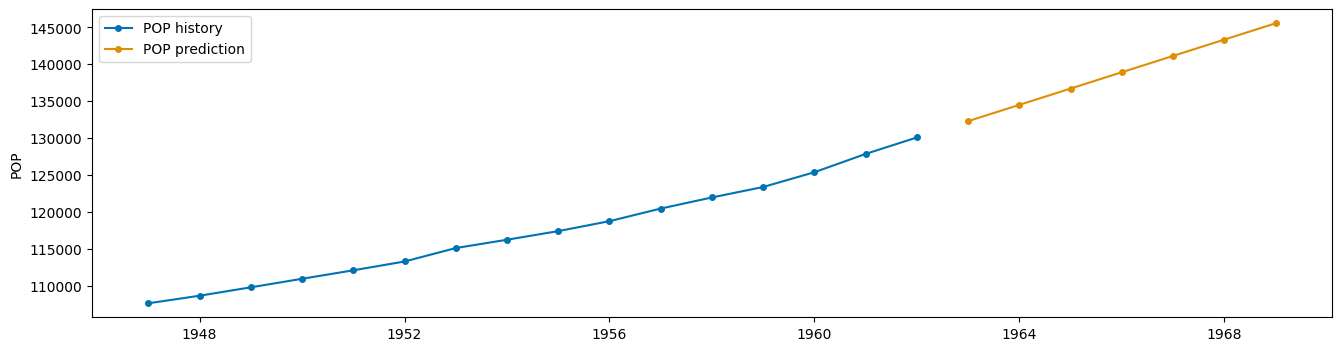

In [31]:
for col in y.columns:
    plot_series(y[col], y_pred[col], labels=[f"{col} history", f"{col} prediction"])

It trains a single model per column of `y` under the hood. Organized in a dataframe, easy access.

In [32]:
ets.forecasters_

,GNPDEFL,GNP,UNEMP,ARMED,POP
forecasters,ExponentialSmoothing(trend='add'),ExponentialSmoothing(trend='add'),ExponentialSmoothing(trend='add'),ExponentialSmoothing(trend='add'),ExponentialSmoothing(trend='add')


In [33]:
ets.forecasters_.loc["forecasters", "GNP"]

ExponentialSmoothing(trend='add')

In [34]:
ets.forecasters_.loc["forecasters", "GNP"].get_fitted_params()

{'initial_level': 211882.3999999999,
 'initial_slope': None,
 'initial_seasons': array([], dtype=float64),
 'aic': 300.6725308623615,
 'bic': 303.7628857513206,
 'aicc': 310.0058641956948}

In [35]:
ets.get_fitted_params()

{'forecasters':                                        GNPDEFL  \
 forecasters  ExponentialSmoothing(trend='add')   
 
                                            GNP  \
 forecasters  ExponentialSmoothing(trend='add')   
 
                                          UNEMP  \
 forecasters  ExponentialSmoothing(trend='add')   
 
                                          ARMED  \
 forecasters  ExponentialSmoothing(trend='add')   
 
                                            POP  
 forecasters  ExponentialSmoothing(trend='add')  ,
 "forecasters.loc['forecasters','GNPDEFL']": ExponentialSmoothing(trend='add'),
 "forecasters.loc['forecasters','GNPDEFL']__initial_level": 82.58490781840031,
 "forecasters.loc['forecasters','GNPDEFL']__initial_slope": None,
 "forecasters.loc['forecasters','GNPDEFL']__initial_seasons": array([], dtype=float64),
 "forecasters.loc['forecasters','GNPDEFL']__aic": 18.471273899153168,
 "forecasters.loc['forecasters','GNPDEFL']__bic": 21.561628788112294,
 "forecasters.l

### Get a real multivariate forecaster

In [36]:
from sktime.registry import all_estimators

all_estimators(
    estimator_types="forecaster",
    filter_tags={"scitype:y": "multivariate"},
    as_dataframe=True,
)

,name,object
0,DynamicFactor,<class 'sktime.forecasting.dynamic_factor.Dyna...
1,VAR,<class 'sktime.forecasting.var.VAR'>
2,VARMAX,<class 'sktime.forecasting.varmax.VARMAX'>
3,VECM,<class 'sktime.forecasting.vecm.VECM'>


In [37]:
from sktime.forecasting.var import VAR

In [38]:
var = VAR().fit(y=y, fh=fh)
y_pred = var.predict()

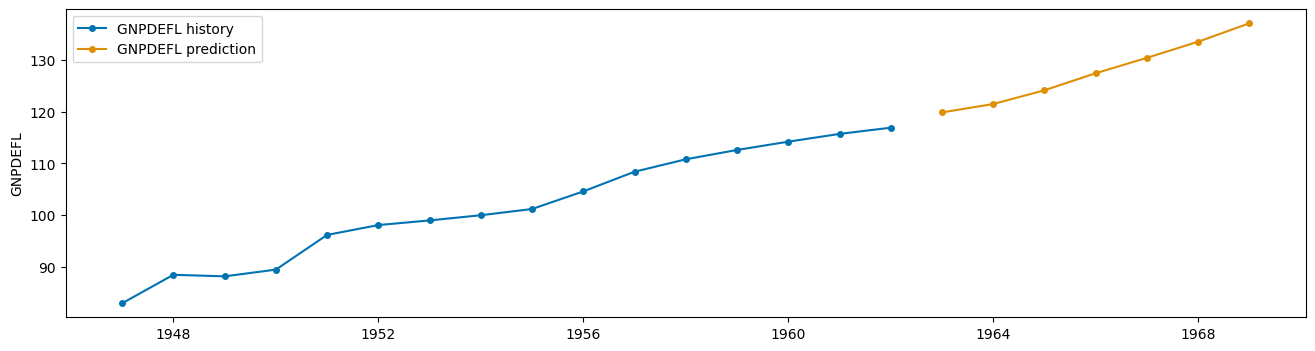

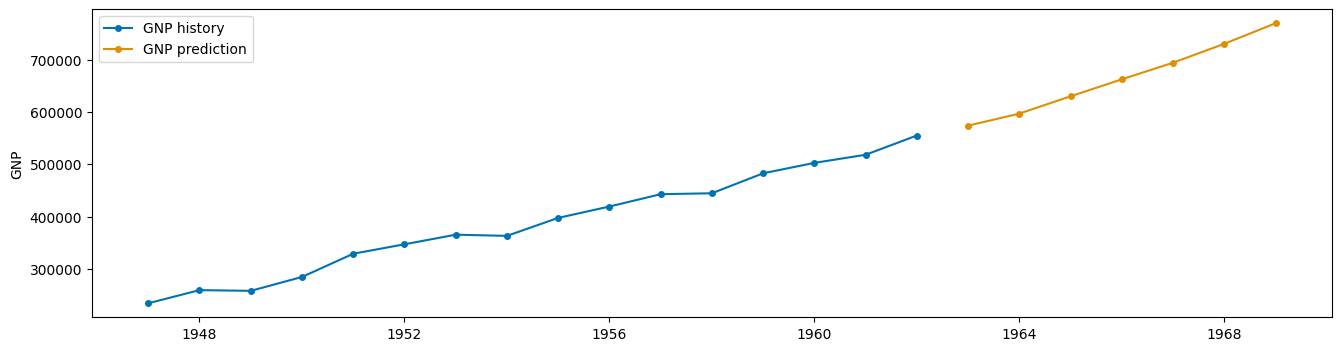

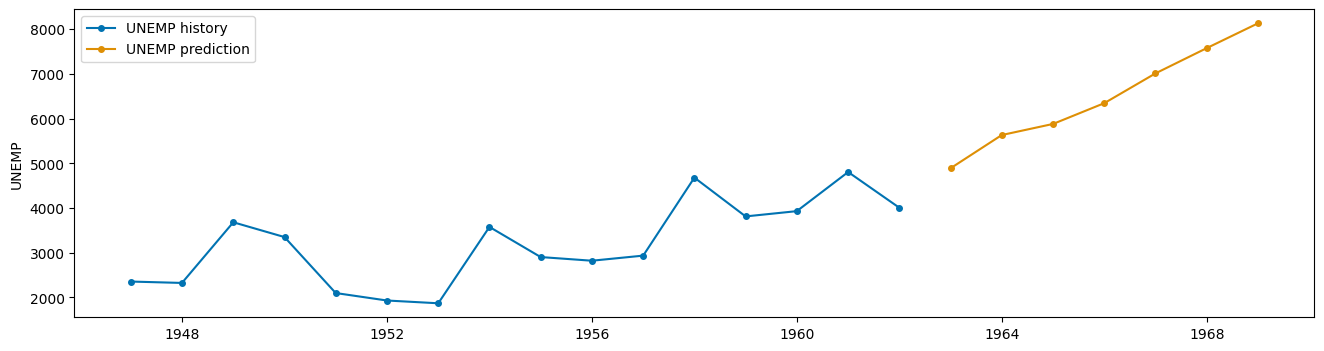

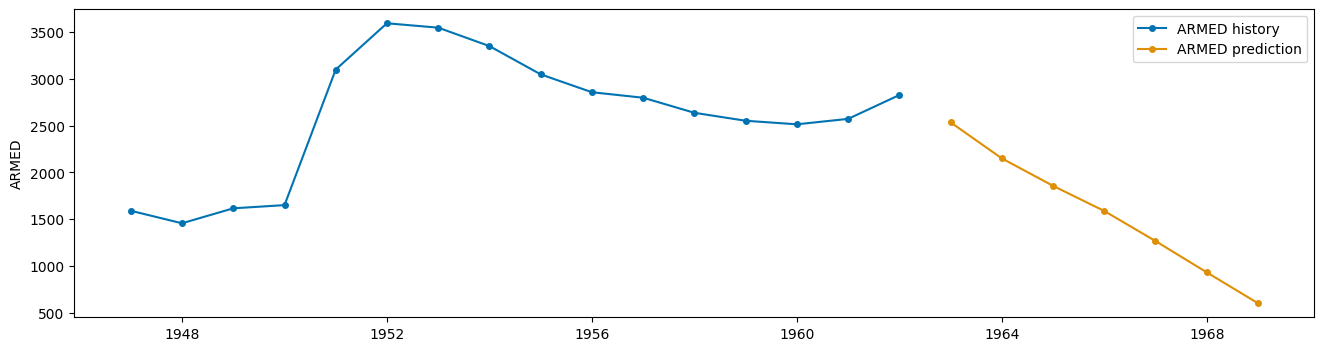

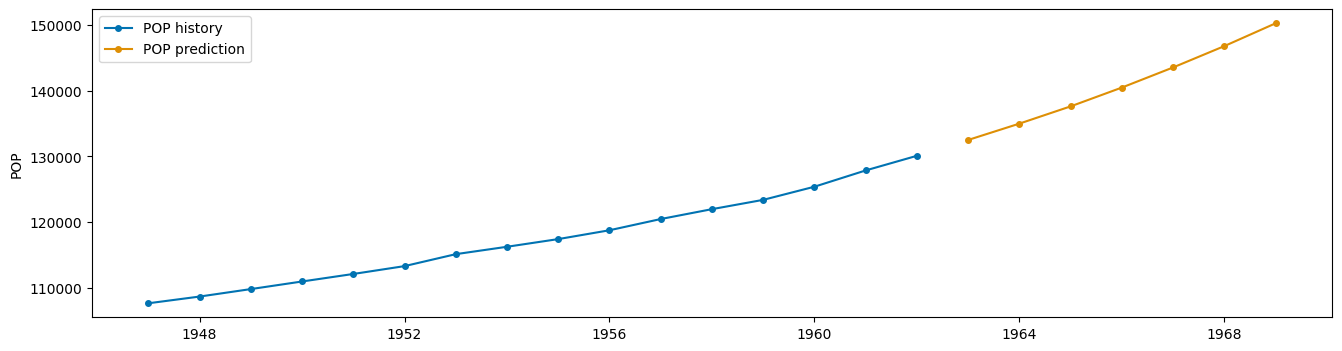

In [39]:
for col in y.columns:
    plot_series(y[col], y_pred[col], labels=[f"{col} history", f"{col} prediction"])

## Use regression models as forecasters
sktime can leverage scikit-learn-compatible models to build ML based forecsasters. But first, let us do it manually.
### Manual way (*Recursive*)
1. Train a model using the last $k$ days to forecast the next one.

<img src="imgs/rec.gif" alt="placeholder" width="70%">

2. To forecast day $h$, plug the last $k$ days before day $h$ into the model. If there is no data for the day, use the previous forecasts instead.
<img src="imgs/rec1.png" alt="placeholder" width="50%">

<img src="imgs/rec2.png" alt="placeholder" width="50%">

<Axes: xlabel='Period'>

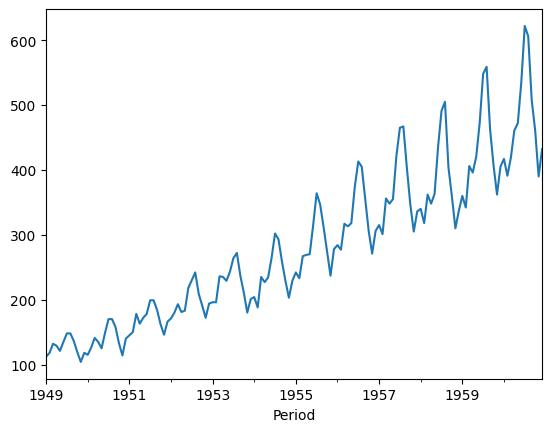

In [40]:
y = load_airline()
fh = np.arange(1, 37)
y.plot()

In [41]:
import numpy as np


def reduce(time_series: np.ndarray, n_lags: int) -> tuple[np.ndarray, np.ndarray]:
    X = []
    y = []

    for window_start in range(len(time_series) - n_lags):
        X.append(time_series[window_start : window_start + n_lags])
        y.append(time_series[window_start + n_lags])

    return np.array(X), np.array(y)

In [42]:
y.head()

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
Freq: M, Name: Number of airline passengers, dtype: float64

In [43]:
X_, y_ = reduce(y, 3)

C:\Users\rober\AppData\Local\Temp\ipykernel_13208\1186916149.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(time_series[window_start + n_lags])


In [44]:
X_[0], y_[0]

(array([112., 118., 132.]), 129.0)

In [45]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_, y_)

LinearRegression()

In [46]:
lr.coef_

array([ 0.2018249 , -0.59184156,  1.34822859])

#### Make a single step forecast

In [47]:
last_observations = y.tail(3).to_numpy()[np.newaxis, :]

lr.predict(last_observations)

array([458.29881774])

**Making a second step is annoying already.**
### sktime way
#### Recursive

In [48]:
from sktime.forecasting.compose import make_reduction

lr_forecaster = make_reduction(LinearRegression(), window_length=3)

lr_forecaster.fit(y, fh=fh)

RecursiveTabularRegressionForecaster(estimator=LinearRegression(),
                                     window_length=3)

Same prediction and coefficients as before!

In [49]:
lr_forecaster.predict().head(1)

1961-01    458.298818
Freq: M, Name: Number of airline passengers, dtype: float64

In [50]:
lr_forecaster.estimator_.coef_

array([ 0.2018249 , -0.59184156,  1.34822859])

Show plot with a longer window length. 12 is a good candidate since it's the seasonality length.

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

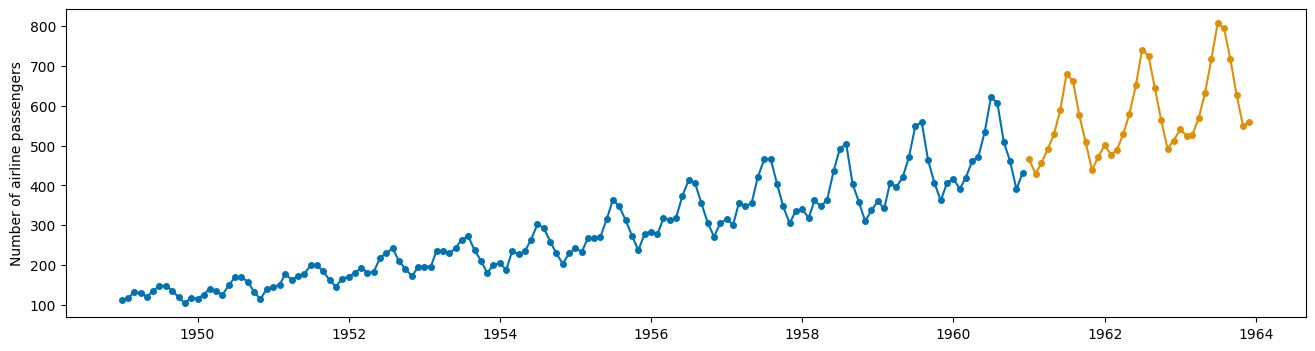

In [51]:
lr_forecaster_rec = make_reduction(LinearRegression(), window_length=12)

lr_forecaster_rec.fit(y, fh=fh)

plot_series(y, lr_forecaster_rec.predict())

### All reductions techniques:
| Method      | Short Explanation                                                                          | # Models | # Features | # Targets |
|-------------|--------------------------------------------------------------------------------------------|----------|------------|-----------|
| Recursive   | Train a model to predict the next value.                                                   | 1        | w          | 1         |
| Direct      | Train one model per forecast horizon.                                                      | fh       | w          | 1         |
| DirRec      | Train one model per forecast horizon. Each model knows the outputs of the previous models. | fh       | w+(1,2,3, ...)        | 1         |
| Multioutput | Train a model to predict everything at once.                                               | 1        | w          | fh        |

### Compare the ML models

In [52]:
lr_forecasters = {
    strategy: make_reduction(
        LinearRegression(),
        strategy=strategy,
        window_length=12,
    )
    for strategy in ["recursive", "direct", "dirrec", "multioutput"]
}

In [53]:
from sktime.benchmarking.forecasting import ForecastingBenchmark

bench = ForecastingBenchmark(backend="loky")

bench.add_task(
    dataset_loader=lambda: y,
    task_id="airline",
    cv_splitter=ExpandingWindowSplitter(
        fh=np.arange(1, 25), initial_window=36, step_length=24
    ),
    scorers=[MeanAbsoluteError()],
)

for strategy, forecaster in lr_forecasters.items():
    bench.add_estimator(forecaster, estimator_id=strategy)

bench.run("results.csv")

,validation_id,model_id,runtime_secs,MeanAbsoluteError_fold_0_test,MeanAbsoluteError_fold_1_test,MeanAbsoluteError_fold_2_test,MeanAbsoluteError_fold_3_test,MeanAbsoluteError_mean,MeanAbsoluteError_std
0,airline,direct,3.295460,56.083333,24.431640,33.152057,39.176942,38.210993,13.364343
1,airline,dirrec,0.097212,56.083333,24.431640,33.152057,39.176942,38.210993,13.364343
2,airline,multioutput,0.059340,56.083333,24.431640,33.152057,39.176942,38.210993,13.364343
3,airline,recursive,4.240561,68.233913,22.541148,16.261295,40.744440,36.945199,23.300346


Recap:

*   Univariate forecasting (Naive, ETS) with model evaluation (train-test split, metrics, backtesting)
*   Forecasting with exogenous variables (SARIMAX)
*   Multivariate time series forecasting (ETS, VAR)
*   Regression models for forecasting (recursive, direct, and DirRec strategies)

### Moving away from linear regression
Let's try a more complex model like the all-time classic **Random Forest**.

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

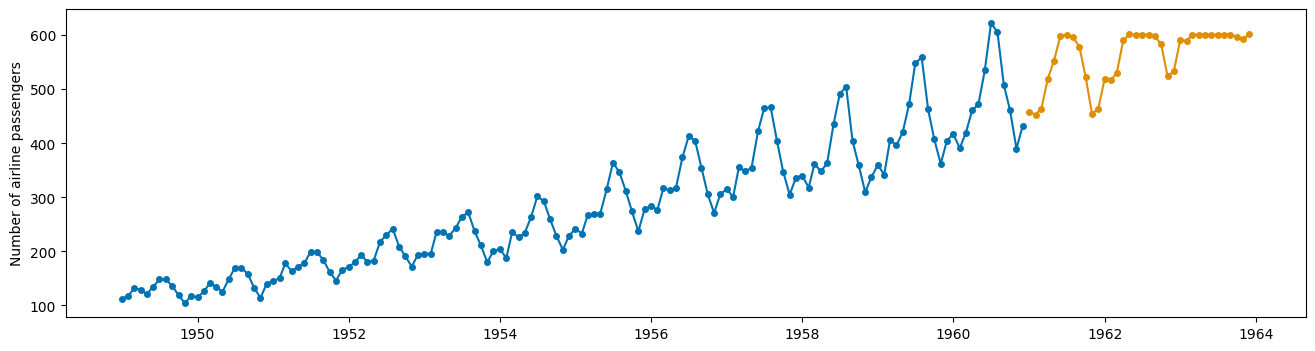

In [54]:
from sklearn.ensemble import RandomForestRegressor

rf_forecaster = make_reduction(RandomForestRegressor(), window_length=12)

rf_forecaster.fit(y, fh=fh)

plot_series(y, rf_forecaster.predict())

### ⚠️ Homework for you: why does this happen? And what to do about it?

#### More in the next lecture!